Import Stuff

In [46]:
import argparse
import time
import numpy as np
from math import ceil
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn.functional as F
from torch import optim

# from model import RW_NN
from utils import load_data, generate_batches, accuracy, AverageMeter

RW_NN Model

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn.parameter import Parameter

class RW_NN(nn.Module):
    # new hyperparameters
    # max_num_children
    def __init__(self, input_dim, max_step, hidden_graphs, size_hidden_graphs, hidden_dim, penultimate_dim, normalize, n_classes, dropout, device):
        super(RW_NN, self).__init__()
        self.max_step = max_step
        self.hidden_graphs = hidden_graphs
        self.size_hidden_graphs = size_hidden_graphs
        self.normalize = normalize
        self.device = device
        self.adj_hidden = Parameter(torch.FloatTensor(hidden_graphs, (size_hidden_graphs*(size_hidden_graphs-1))//2))
        self.features_hidden = Parameter(torch.FloatTensor(hidden_graphs, size_hidden_graphs, hidden_dim))
        self.fc = torch.nn.Linear(input_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_graphs*max_step)
        self.fc1 = torch.nn.Linear(hidden_graphs*max_step, penultimate_dim)
        self.fc2 = torch.nn.Linear(penultimate_dim, n_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.init_weights()

    def init_weights(self):
        self.adj_hidden.data.uniform_(-1, 1)
        self.features_hidden.data.uniform_(0, 1)

        
    def forward(self, adj, features, graph_indicator):
        unique, counts = torch.unique(graph_indicator, return_counts=True)
        n_graphs = unique.size(0)
        n_nodes = features.size(0)

        if self.normalize:
            norm = counts.unsqueeze(1).repeat(1, self.hidden_graphs)
        
        adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
        idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
        adj_hidden_norm[:,idx[0],idx[1]] = self.relu(self.adj_hidden)
        adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
        x = self.sigmoid(self.fc(features))
        z = self.features_hidden
        zx = torch.einsum("abc,dc->abd", (z, x))
        
        out = list()
        for i in range(self.max_step):
            if i == 0:
                eye = torch.eye(self.size_hidden_graphs, device=self.device)
                eye = eye.repeat(self.hidden_graphs, 1, 1)              
                o = torch.einsum("abc,acd->abd", (eye, z))
                t = torch.einsum("abc,dc->abd", (o, x))
            else:
                x = torch.spmm(adj, x)
                z = torch.einsum("abc,acd->abd", (adj_hidden_norm, z))
                t = torch.einsum("abc,dc->abd", (z, x))
            t = self.dropout(t)
            t = torch.mul(zx, t)
            t = torch.zeros(t.size(0), t.size(1), n_graphs, device=self.device).index_add_(2, graph_indicator, t)
            t = torch.sum(t, dim=1)
            t = torch.transpose(t, 0, 1)
            if self.normalize:
                t /= norm
            out.append(t)
            
        out = torch.cat(out, dim=1)
        out = self.bn(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return F.log_softmax(out, dim=1)
    def get_hidden_graphs_adjacency_list(self):
        """Converts the upper-triangular adjacency data to adjacency lists."""
        adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
        idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
        adj_hidden_norm[:, idx[0], idx[1]] = self.relu(self.adj_hidden)
        adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
        
        # Convert each hidden graph's adjacency matrix to an adjacency list
        adjacency_lists = []
        for i in range(self.hidden_graphs):
            adj_list = {}
            adj_matrix = adj_hidden_norm[i].detach().cpu().numpy()  # Move to CPU for easy processing
            for row in range(adj_matrix.shape[0]):
                adj_list[row] = list(np.where(adj_matrix[row] > 0)[0])  # Find connected nodes
            adjacency_lists.append(adj_list)
        
        return adjacency_lists

Hyperparameters for RWNN

In [48]:
# settings
from types import SimpleNamespace
args = SimpleNamespace(
    dataset='synthetic',
    use_node_labels=False,
    lr=1e-2,
    dropout=0.2,
    batch_size=64,
    epochs=5,
    hidden_graphs=8,
    size_hidden_graphs=5,
    hidden_dim=4,
    penultimate_dim=32,
    max_step=2,
    normalize=False,
)

Generate random graphs for synthetic dataset

In [49]:
import matplotlib.pyplot as plt
import networkx as nx
import random

open("graph_A.txt", "w").close()

open("graph_indicator.txt", "w").close()
open("graph_labels.txt", "w").close()
graph_indicator = 1
random_num = random.randint(5, 30)
random_graphs = []
for _ in range(25):
    n = random_num  # 10 nodes
    m = random_num  # 20 edges
    # seed = 42  # seed random number generators for reproducibility

    # Use seed for reproducibility
    G = nx.gnm_random_graph(n, m)
    random_graphs.append(G)
    # some properties
    # print("node degree clustering")
    # for v in nx.nodes(G):
    #     print(f"{v} {nx.degree(G, v)} {nx.clustering(G, v)}")

    # print()
    print(nx.generate_adjlist(G))
    pairs = []

    for line in nx.generate_adjlist(G):
        # Split the line into nodes
        nodes = line.split()
        # The first node is the source, and the rest are targets
        source = nodes[0]
        targets = nodes[1:]
        
        # Generate (source, target) pairs
        for target in targets:
            print(str(int(source) + 1))
            pairs.append((str(int(source) + 1), str(int(target) + 1)))
    print(pairs)
    # Write the result to a file
    with open("graph_A.txt", "a") as f:
        for pair in pairs:
            f.write(f"{pair[0]}, {pair[1]}\n")

    with open("graph_indicator.txt", "a") as f:
        for pair in pairs:
            f.write(f"{graph_indicator}\n")
    with open("graph_labels.txt", "a") as f:
        f.write(f"0\n")
        graph_indicator += 1

<generator object generate_adjlist at 0x16bf632e0>
1
1
1
1
1
2
3
3
5
5
6
9
10
11
11
11
12
12
13
14
16
[('1', '21'), ('1', '9'), ('1', '14'), ('1', '3'), ('1', '16'), ('2', '15'), ('3', '20'), ('3', '6'), ('5', '18'), ('5', '13'), ('6', '21'), ('9', '16'), ('10', '19'), ('11', '15'), ('11', '12'), ('11', '18'), ('12', '19'), ('12', '17'), ('13', '14'), ('14', '20'), ('16', '21')]
<generator object generate_adjlist at 0x16bf63f20>
1
3
4
4
4
4
5
6
7
7
8
9
10
10
12
13
13
14
14
16
19
[('1', '6'), ('3', '10'), ('4', '7'), ('4', '19'), ('4', '21'), ('4', '5'), ('5', '12'), ('6', '21'), ('7', '19'), ('7', '16'), ('8', '21'), ('9', '17'), ('10', '17'), ('10', '11'), ('12', '13'), ('13', '15'), ('13', '20'), ('14', '16'), ('14', '15'), ('16', '18'), ('19', '21')]
<generator object generate_adjlist at 0x16bf63f20>
1
1
1
1
2
2
4
6
6
7
7
7
11
12
12
13
13
14
14
15
17
[('1', '15'), ('1', '10'), ('1', '6'), ('1', '21'), ('2', '4'), ('2', '19'), ('4', '9'), ('6', '20'), ('6', '9'), ('7', '20'), ('7', '

In [50]:
import matplotlib.pyplot as plt
import networkx as nx
import random
   
random_num = random.randint(5, 30)
random_graphs = []
for _ in range(25):
    n = random_num  # 10 nodes
    m = random_num  # 20 edges
    # seed = 42  # seed random number generators for reproducibility

    # Use seed for reproducibility
    G = nx.cycle_graph(n)
    random_graphs.append(G)
    # some properties
    # print("node degree clustering")
    # for v in nx.nodes(G):
    #     print(f"{v} {nx.degree(G, v)} {nx.clustering(G, v)}")

    # print()
    pairs = []

    for line in nx.generate_adjlist(G):
        # Split the line into nodes
        nodes = line.split()
        # The first node is the source, and the rest are targets
        source = nodes[0]
        targets = nodes[1:]
        
        # Generate (source, target) pairs
        for target in targets:
            pairs.append((str(int(source) + 1), str(int(target) + 1)))
        
    # Write the result to a file
    with open("graph_A.txt", "a") as f:
        for pair in pairs:
            f.write(f"{pair[0]}, {pair[1]}\n")
    with open("graph_indicator.txt", "a") as f:
        for pair in pairs:
            f.write(f"{graph_indicator}\n")
    with open("graph_labels.txt", "a") as f:
        f.write(f"1\n")
        graph_indicator += 1

In [51]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Encoder

In [52]:
adj_lst, features_lst, class_labels = load_data(args.dataset, args.use_node_labels)

N = len(adj_lst)
features_dim = features_lst[0].shape[1]

enc = LabelEncoder()
class_labels = enc.fit_transform(class_labels)
n_classes = np.unique(class_labels).size
y = [np.array(class_labels[i]) for i in range(class_labels.size)]

kf = KFold(n_splits=10, shuffle=True, random_state=13)
it = 0
accs = list()

Train and test model

In [53]:
model = []

for train_index, test_index in kf.split(y):
    it += 1
    
    idx = np.random.permutation(train_index)
    train_index = idx[:int(idx.size*0.9)].tolist()
    val_index = idx[int(idx.size*0.9):].tolist()

    n_train = len(train_index)
    n_val = len(val_index)
    n_test = len(test_index)

    adj_train = [adj_lst[i] for i in train_index]
    features_train = [features_lst[i] for i in train_index]
    y_train = [y[i] for i in train_index]

    adj_val = [adj_lst[i] for i in val_index]
    features_val = [features_lst[i] for i in val_index]
    y_val = [y[i] for i in val_index]

    adj_test = [adj_lst[i] for i in test_index]
    features_test = [features_lst[i] for i in test_index]
    y_test = [y[i] for i in test_index]

    adj_train, features_train, graph_indicator_train, y_train = generate_batches(adj_train, features_train, y_train, args.batch_size, device)
    adj_val, features_val, graph_indicator_val, y_val = generate_batches(adj_val, features_val, y_val, args.batch_size, device)
    adj_test, features_test, graph_indicator_test, y_test = generate_batches(adj_test, features_test, y_test, args.batch_size, device)

    n_train_batches = ceil(n_train/args.batch_size)
    n_val_batches = ceil(n_val/args.batch_size)
    n_test_batches = ceil(n_test/args.batch_size)
    
    model = RW_NN(features_dim, args.max_step, args.hidden_graphs, args.size_hidden_graphs, args.hidden_dim, args.penultimate_dim, args.normalize, n_classes, args.dropout, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    def train(epoch, adj, features, graph_indicator, y):
        optimizer.zero_grad()
        output = model(adj, features, graph_indicator)
        loss_train = F.cross_entropy(output, y)
        loss_train.backward()
        optimizer.step()
        return output, loss_train

    def test(adj, features, graph_indicator, y):
        output = model(adj, features, graph_indicator)
        loss_test = F.cross_entropy(output, y)
        return output, loss_test

    best_acc = 0

    for epoch in range(args.epochs):
        start = time.time()
        model.train()
        train_loss = AverageMeter()
        train_acc = AverageMeter()

        # Train for one epoch
        for i in range(n_train_batches):
            output, loss = train(epoch, adj_train[i], features_train[i], graph_indicator_train[i], y_train[i])
            train_loss.update(loss.item(), output.size(0))
            train_acc.update(accuracy(output.data, y_train[i].data), output.size(0))

        # Evaluate on validation set
        model.eval()
        val_loss = AverageMeter()
        val_acc = AverageMeter()

        for i in range(n_val_batches):
            output, loss = test(adj_val[i], features_val[i], graph_indicator_val[i], y_val[i])
            val_loss.update(loss.item(), output.size(0))
            val_acc.update(accuracy(output.data, y_val[i].data), output.size(0))

        scheduler.step()
        
        # Print results
        print("Cross-val iter:", '%02d' % it, "epoch:", '%03d' % (epoch + 1), "train_loss=", "{:.5f}".format(train_loss.avg),
            "train_acc=", "{:.5f}".format(train_acc.avg), "val_loss=", "{:.5f}".format(val_loss.avg),
            "val_acc=", "{:.5f}".format(val_acc.avg), "time=", "{:.5f}".format(time.time() - start))
        
        # Remember best accuracy and save checkpoint
        is_best = val_acc.avg >= best_acc
        best_acc = max(val_acc.avg, best_acc)
        if is_best:
            early_stopping_counter = 0
            torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            }, 'model_best.pth.tar')

    print("Optimization finished!")

    # Testing
    test_loss = AverageMeter()
    test_acc = AverageMeter()
    print("Loading checkpoint!")
    checkpoint = torch.load('model_best.pth.tar')
    epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    for i in range(n_test_batches):
        output, loss = test(adj_test[i], features_test[i], graph_indicator_test[i], y_test[i])
        test_loss.update(loss.item(), output.size(0))
        test_acc.update(accuracy(output.data, y_test[i].data), output.size(0))
    accs.append(test_acc.avg.cpu().numpy())

    # Print results
    print("test_loss=", "{:.5f}".format(test_loss.avg), "test_acc=", "{:.5f}".format(test_acc.avg))
    print()
    
print("avg_test_acc=", "{:.5f}".format(np.mean(accs)))

Cross-val iter: 01 epoch: 001 train_loss= 0.68610 train_acc= 0.60000 val_loss= 3.72040 val_acc= 0.20000 time= 0.10699
Cross-val iter: 01 epoch: 002 train_loss= 0.68281 train_acc= 0.52500 val_loss= 5.04010 val_acc= 0.20000 time= 0.01287
Cross-val iter: 01 epoch: 003 train_loss= 0.69708 train_acc= 0.55000 val_loss= 4.08212 val_acc= 0.20000 time= 0.00975
Cross-val iter: 01 epoch: 004 train_loss= 0.69760 train_acc= 0.42500 val_loss= 3.85721 val_acc= 0.20000 time= 0.00606
Cross-val iter: 01 epoch: 005 train_loss= 0.72242 train_acc= 0.45000 val_loss= 3.48020 val_acc= 0.20000 time= 0.00487
Optimization finished!
Loading checkpoint!
test_loss= 262.62421 test_acc= 0.40000

Cross-val iter: 02 epoch: 001 train_loss= 0.65898 train_acc= 0.60000 val_loss= 20.59178 val_acc= 0.40000 time= 0.00629
Cross-val iter: 02 epoch: 002 train_loss= 0.67767 train_acc= 0.47500 val_loss= 12.80246 val_acc= 0.40000 time= 0.00331
Cross-val iter: 02 epoch: 003 train_loss= 0.66514 train_acc= 0.57500 val_loss= 10.19916 v

/var/folders/qp/2rm9qtrn4bx8cwcdd8dr1f980000gn/T/ipykernel_51215/258026875.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_best.pth.tar')

Cross-val iter: 05 epoch: 002 train_loss= 0.69322 train_acc= 0.47500 val_loss= 2.98334 val_acc= 0.40000 time= 0.00631
Cross-val iter: 05 epoch: 003 train_loss= 0.65770 train_acc= 0.57500 val_loss= 2.15817 val_acc= 0.40000 time= 0.00262
Cross-val iter: 05 epoch: 004 train_loss= 0.67238 train_acc= 0.57500 val_loss= 1.56203 val_acc= 0.40000 time= 0.00296
Cross-val iter: 05 epoch: 005 train_loss= 0.67340 train_acc= 0.52500 val_loss= 1.41284 val_acc= 0.40000 time= 0.00246
Optimization finished!
Loading checkpoint!
test_loss= 1.41284 test_acc= 0.40000

Cross-val iter: 06 epoch: 001 train_loss= 0.70578 train_acc= 0.40000 val_loss= 7.17698 val_acc= 0.40000 time= 0.00278
Cross-val iter: 06 epoch: 002 train_loss= 0.69290 train_acc= 0.50000 val_loss= 8.16115 val_acc= 0.40000 time= 0.00259
Cross-val iter: 06 epoch: 003 train_loss= 0.68523 train_acc= 0.55000 val_loss= 7.28869 val_acc= 0.40000 time= 0.00310
Cross-val iter: 06 epoch: 004 train_loss= 0.69055 train_acc= 0.52500 val_loss= 6.28600 val_ac

Print adjacency lists of hidden graphs

In [54]:
adjacency_lists = model.get_hidden_graphs_adjacency_list()

# Print the adjacency lists for each hidden graph
for i, adj_list in enumerate(adjacency_lists):
    print(f"Hidden Graph {i}:")
    for node, neighbors in adj_list.items():
        print(f"  Node {node}: {neighbors}")

Hidden Graph 0:
  Node 0: [np.int64(1), np.int64(3)]
  Node 1: [np.int64(0), np.int64(3), np.int64(4)]
  Node 2: [np.int64(3)]
  Node 3: [np.int64(0), np.int64(1), np.int64(2), np.int64(4)]
  Node 4: [np.int64(1), np.int64(3)]
Hidden Graph 1:
  Node 0: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
  Node 1: [np.int64(0), np.int64(3)]
  Node 2: [np.int64(0)]
  Node 3: [np.int64(0), np.int64(1), np.int64(4)]
  Node 4: [np.int64(0), np.int64(3)]
Hidden Graph 2:
  Node 0: [np.int64(3), np.int64(4)]
  Node 1: [np.int64(3), np.int64(4)]
  Node 2: []
  Node 3: [np.int64(0), np.int64(1), np.int64(4)]
  Node 4: [np.int64(0), np.int64(1), np.int64(3)]
Hidden Graph 3:
  Node 0: [np.int64(3), np.int64(4)]
  Node 1: [np.int64(2), np.int64(3)]
  Node 2: [np.int64(1), np.int64(3)]
  Node 3: [np.int64(0), np.int64(1), np.int64(2), np.int64(4)]
  Node 4: [np.int64(0), np.int64(3)]
Hidden Graph 4:
  Node 0: [np.int64(3)]
  Node 1: []
  Node 2: [np.int64(3)]
  Node 3: [np.int64(0), np.int64(2)]
  

Display all hidden graphs

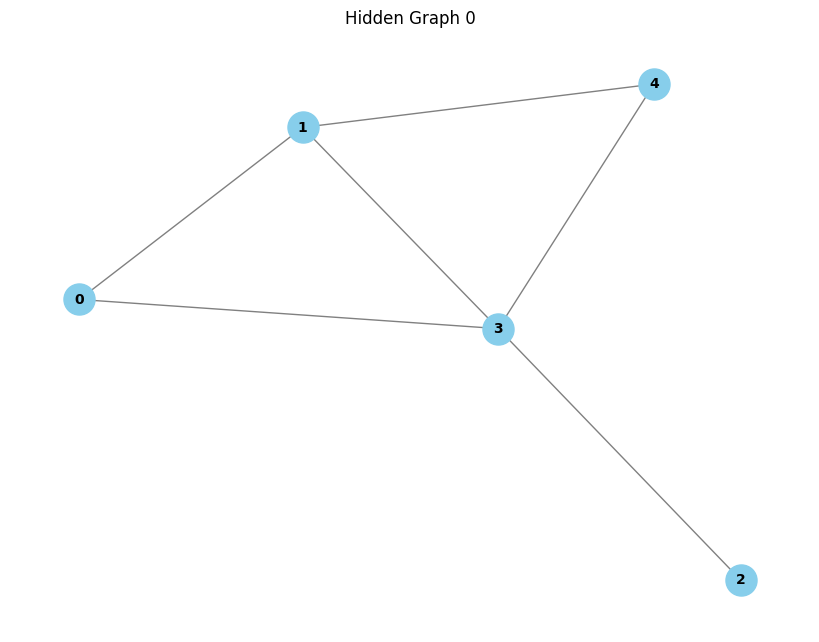

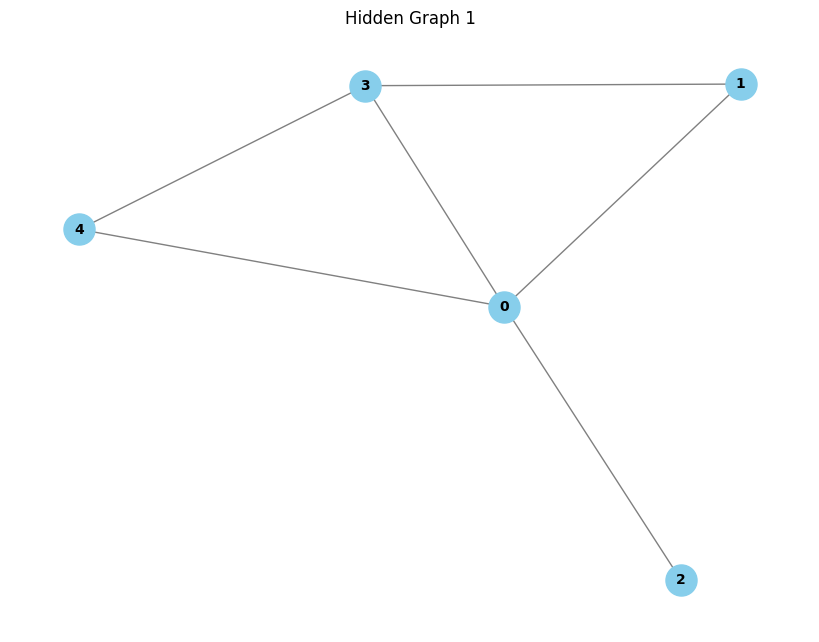

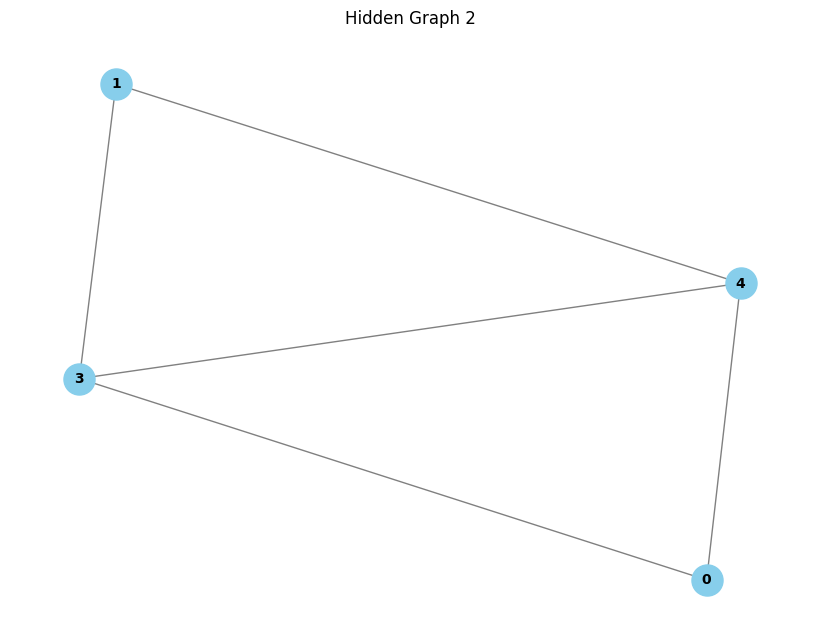

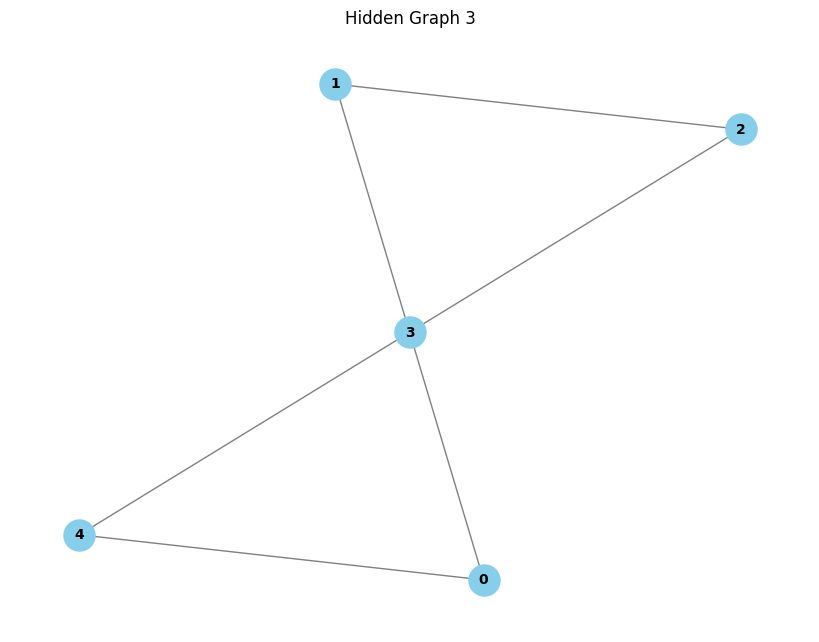

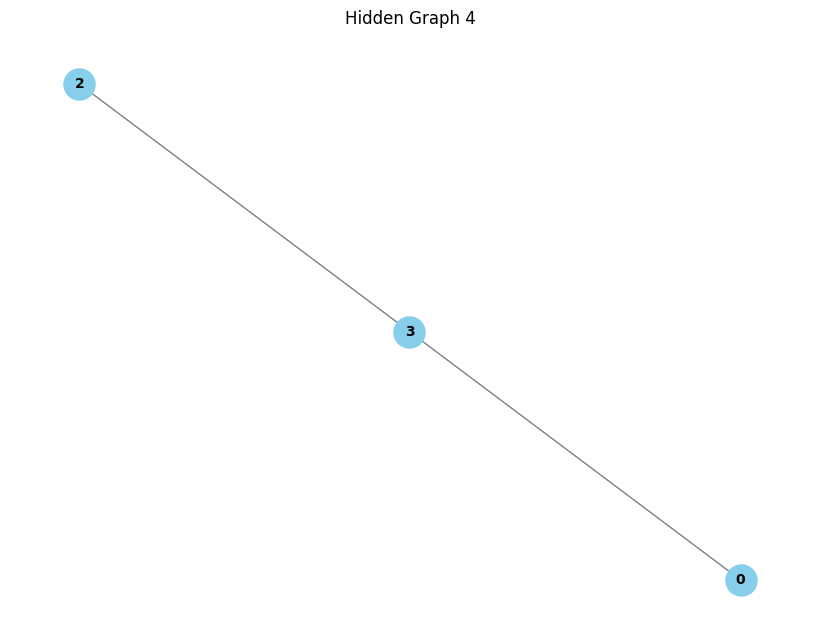

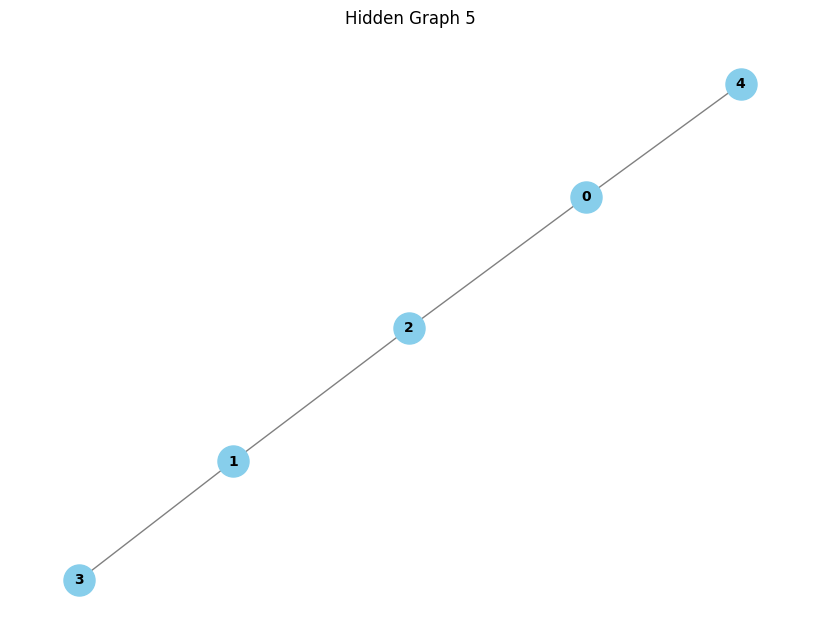

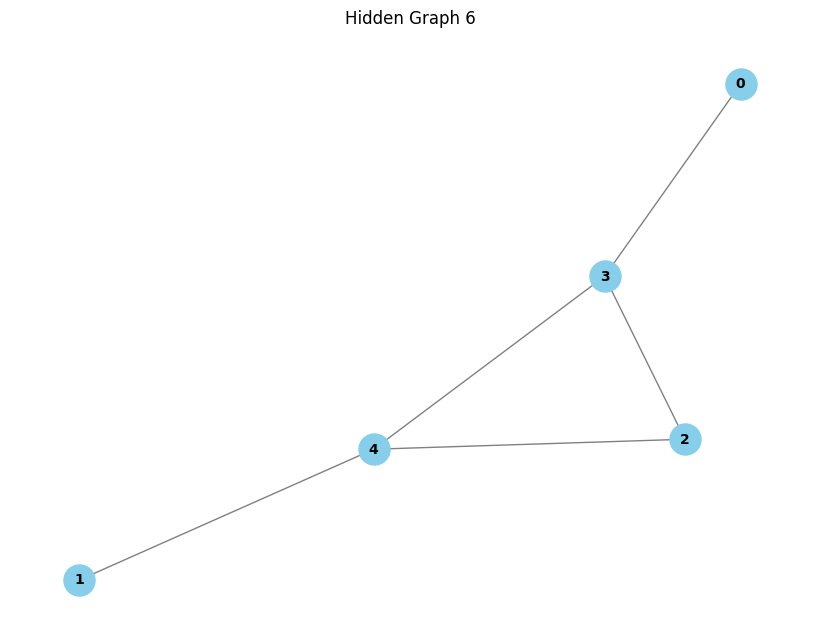

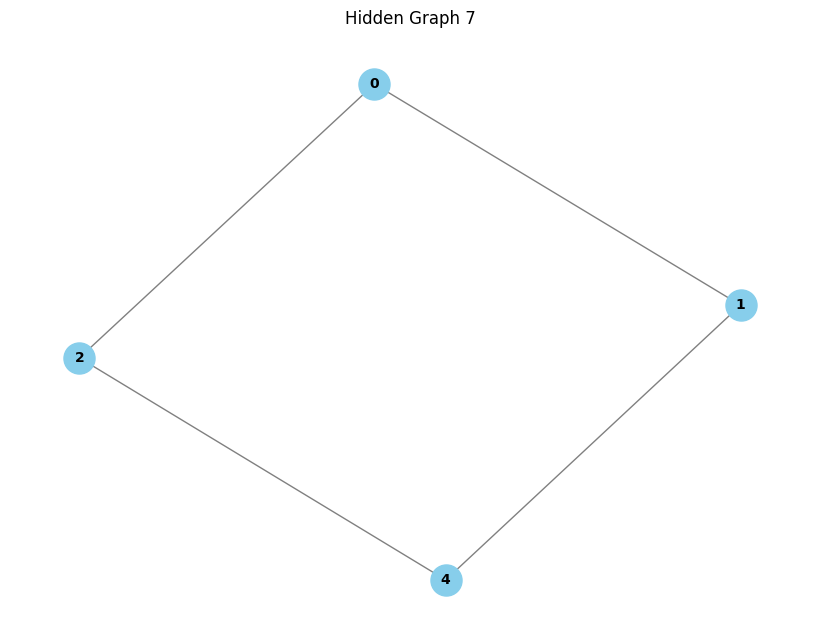

In [55]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming model is defined and adjacency lists are obtained as follows:
adjacency_lists = model.get_hidden_graphs_adjacency_list()

# Draw the adjacency list as a graph using NetworkX and Matplotlib
for i, adj_list in enumerate(adjacency_lists):
    G = nx.Graph()  # Create a new graph
    # Add edges to the graph based on the adjacency list
    for node, neighbors in adj_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    # Draw the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # Positioning the nodes using the spring layout
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
    plt.title(f"Hidden Graph {i}")
    plt.show()


Test if two hidden graphs are isomorphic

In [56]:
adjacency_lists = model.get_hidden_graphs_adjacency_list()

graphs = []

# Draw the adjacency list as a graph using NetworkX and Matplotlib
for i, adj_list in enumerate(adjacency_lists):
    G = nx.Graph()  # Create a new graph
    # Add edges to the graph based on the adjacency list
    for node, neighbors in adj_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    
    for j, graph in enumerate(graphs):
        if nx.is_isomorphic(graph, G):
            print("Graph", i, "is isomorphic to previous graph", j)

    graphs.append(G)
    

Graph 1 is isomorphic to previous graph 0


Edit distance between hidden graphs

In [57]:
graph_dist_adj_matrix = np.zeros(shape=(len(graphs),len(graphs)))

for i, graph_1 in enumerate(graphs):
    for j, graph_2 in enumerate(graphs):
        if i == j:
            continue

        graph_edit_distance = nx.graph_edit_distance(graph_1, graph_2)
        print('Edit distance between graph', i, ' and graph', j, ':', graph_edit_distance)
        graph_dist_adj_matrix[i, j] = graph_edit_distance
        
print(graph_dist_adj_matrix)

Edit distance between graph 0  and graph 1 : 0.0
Edit distance between graph 0  and graph 2 : 2.0
Edit distance between graph 0  and graph 3 : 2.0
Edit distance between graph 0  and graph 4 : 6.0
Edit distance between graph 0  and graph 5 : 2.0
Edit distance between graph 0  and graph 6 : 1.0
Edit distance between graph 0  and graph 7 : 3.0
Edit distance between graph 1  and graph 0 : 0.0
Edit distance between graph 1  and graph 2 : 2.0
Edit distance between graph 1  and graph 3 : 2.0
Edit distance between graph 1  and graph 4 : 6.0
Edit distance between graph 1  and graph 5 : 2.0
Edit distance between graph 1  and graph 6 : 1.0
Edit distance between graph 1  and graph 7 : 3.0
Edit distance between graph 2  and graph 0 : 2.0
Edit distance between graph 2  and graph 1 : 2.0
Edit distance between graph 2  and graph 3 : 4.0
Edit distance between graph 2  and graph 4 : 4.0
Edit distance between graph 2  and graph 5 : 4.0
Edit distance between graph 2  and graph 6 : 3.0
Edit distance betwee

Generate metagraph

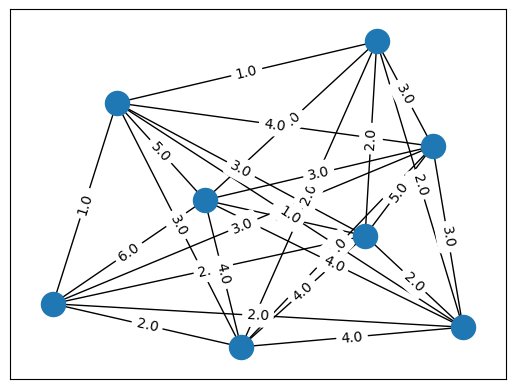

In [62]:
G = nx.from_numpy_array(graph_dist_adj_matrix)

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos)

labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.show()

Louvain Community Detection

In [60]:
import networkx as nx
nx.community.louvain_communities(G)

[{0, 1, 2, 3, 4, 5, 6, 7}]

K-Means Clustering on metagraph

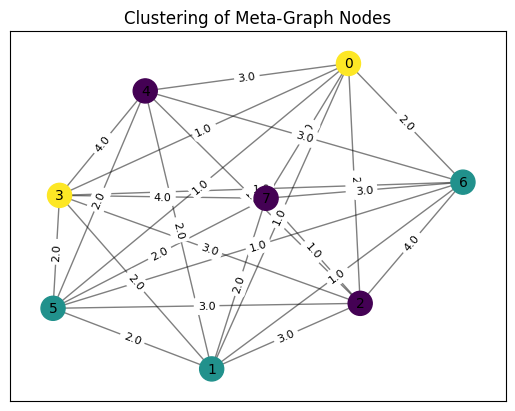

In [23]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# use metagraph adjacency matrix as node features
node_features = graph_dist_adj_matrix

# apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
reduced_features = pca.fit_transform(node_features)

# apply clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_features)

# visualize metagraph with cluster labels
pos = nx.spring_layout(G)  # Spring layout for visualization
nx.draw_networkx_nodes(G, pos, node_color=cluster_labels, cmap='viridis', node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw edge labels (weights)
weights = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_size=8)


# Add labels (optional)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Clustering of Meta-Graph Nodes")
plt.show()


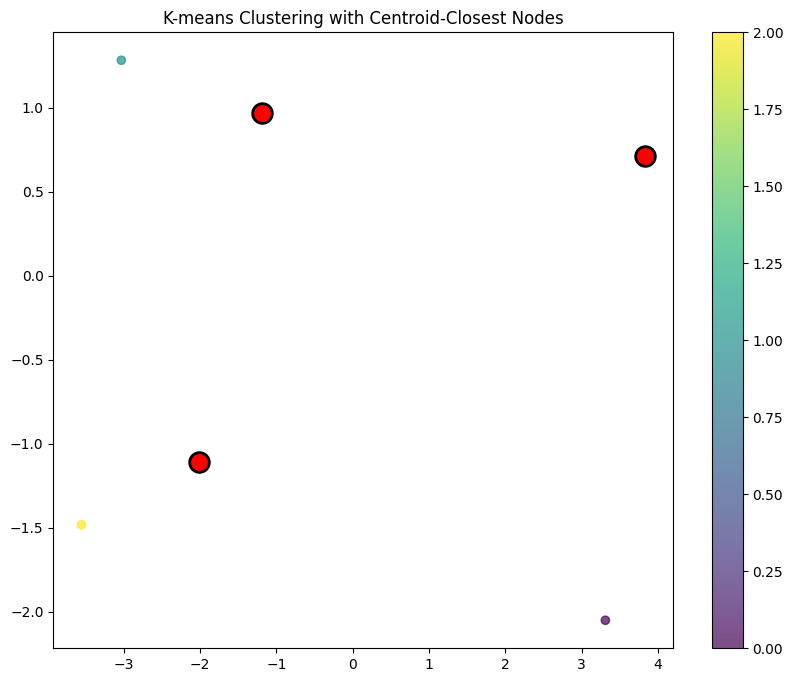

Indices of nodes closest to centroids: [np.int64(4), np.int64(5), np.int64(0)]


In [72]:
# Get centroids
centroids = kmeans.cluster_centers_

# Calculate distances from each point to its cluster centroid
distances_to_centroids = np.min(
    np.sqrt(np.sum((reduced_features - centroids[cluster_labels])**2, axis=1))
)

# Select nodes closest to centroids
def select_closest_nodes(reduced_features, cluster_labels, centroids, k_per_cluster=1):
    closest_nodes_per_cluster = []
    
    for cluster in range(num_clusters):
        # Get indices of nodes in this cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]
        
        # Get centroids for this cluster
        cluster_centroid = centroids[cluster]
        
        # Calculate distances of cluster nodes to their centroid
        cluster_node_features = reduced_features[cluster_indices]
        distances = np.sqrt(np.sum((cluster_node_features - cluster_centroid)**2, axis=1))
        
        # Select k closest nodes for this cluster
        closest_nodes_indices = cluster_indices[np.argsort(distances)[:k_per_cluster]]
        closest_nodes_per_cluster.extend(closest_nodes_indices)
    
    return closest_nodes_per_cluster

# Get closest nodes (1 per cluster by default)
closest_nodes = select_closest_nodes(reduced_features, cluster_labels, centroids)

# Visualization with highlighted closest nodes
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                      c=cluster_labels, cmap='viridis', alpha=0.7)

# Highlight closest nodes
plt.scatter(reduced_features[closest_nodes, 0], 
            reduced_features[closest_nodes, 1], 
            color='red', 
            s=200, 
            edgecolors='black', 
            linewidth=2)

plt.title("K-means Clustering with Centroid-Closest Nodes")
plt.colorbar(scatter)
plt.show()

# Print or use the closest nodes indices
print("Indices of nodes closest to centroids:", closest_nodes)

Girvin Newman Community Detection

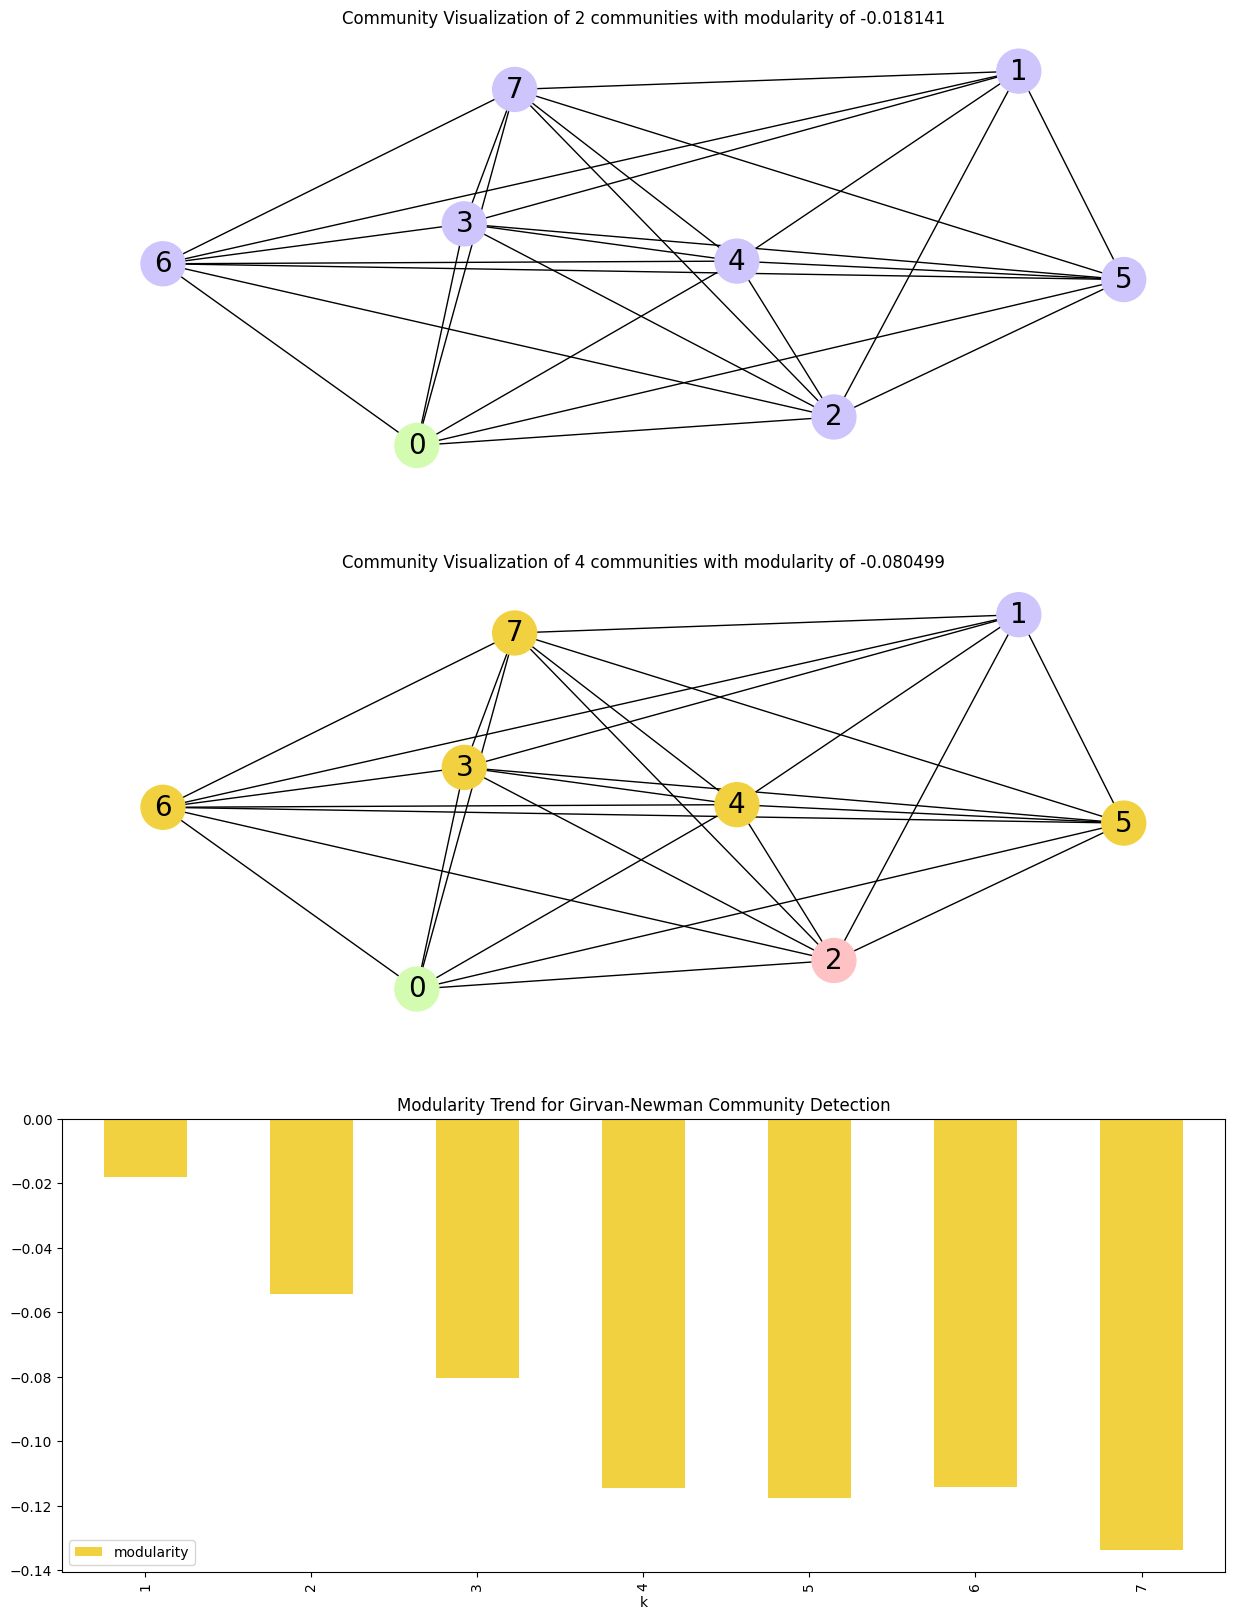

In [64]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Load karate graph and find communities using Girvan-Newman
# G = nx.karate_club_graph()
communities = list(nx.community.girvan_newman(G))

# Modularity -> measures the strength of division of a network into modules
modularity_df = pd.DataFrame(
    [
        [k + 1, nx.community.modularity(G, communities[k])]
        for k in range(len(communities))
    ],
    columns=["k", "modularity"],
)


# function to create node colour list
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities)
    colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "#BCC6C8"][:number_of_colors]
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors


# function to plot graph with node colouring based on communities
def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx.community.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    plt.subplot(3, 1, i)
    plt.title(title)
    nx.draw(
        graph,
        pos=pos,
        node_size=1000,
        node_color=node_colors,
        with_labels=True,
        font_size=20,
        font_color="black",
    )


fig, ax = plt.subplots(3, figsize=(15, 20))

# Plot graph with colouring based on communities
visualize_communities(G, communities[0], 1)
visualize_communities(G, communities[2], 2)

# Plot change in modularity as the important edges are removed
modularity_df.plot.bar(
    x="k",
    ax=ax[2],
    color="#F2D140",
    title="Modularity Trend for Girvan-Newman Community Detection",
)
plt.show()

Spectral Clustering

In [65]:
from sklearn.cluster import SpectralClustering
import numpy as np

# Ensure the matrix is symmetric and non-negative
graph_dist_adj_matrix = np.maximum(graph_dist_adj_matrix, graph_dist_adj_matrix.T)

# Perform spectral clustering
n_clusters = 3  # Adjust based on your expected number of communities
spectral_clustering = SpectralClustering(
    n_clusters=n_clusters, 
    affinity='precomputed', 
    assign_labels='discretize'
)

# Fit the clustering
community_labels = spectral_clustering.fit_predict(graph_dist_adj_matrix)

In [73]:
!pip install seaborn
!pip install python-louvain


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: python-louvain is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for python-louvain ... done

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


AttributeError: QuadMesh.set() got an unexpected keyword argument 'row_colors'

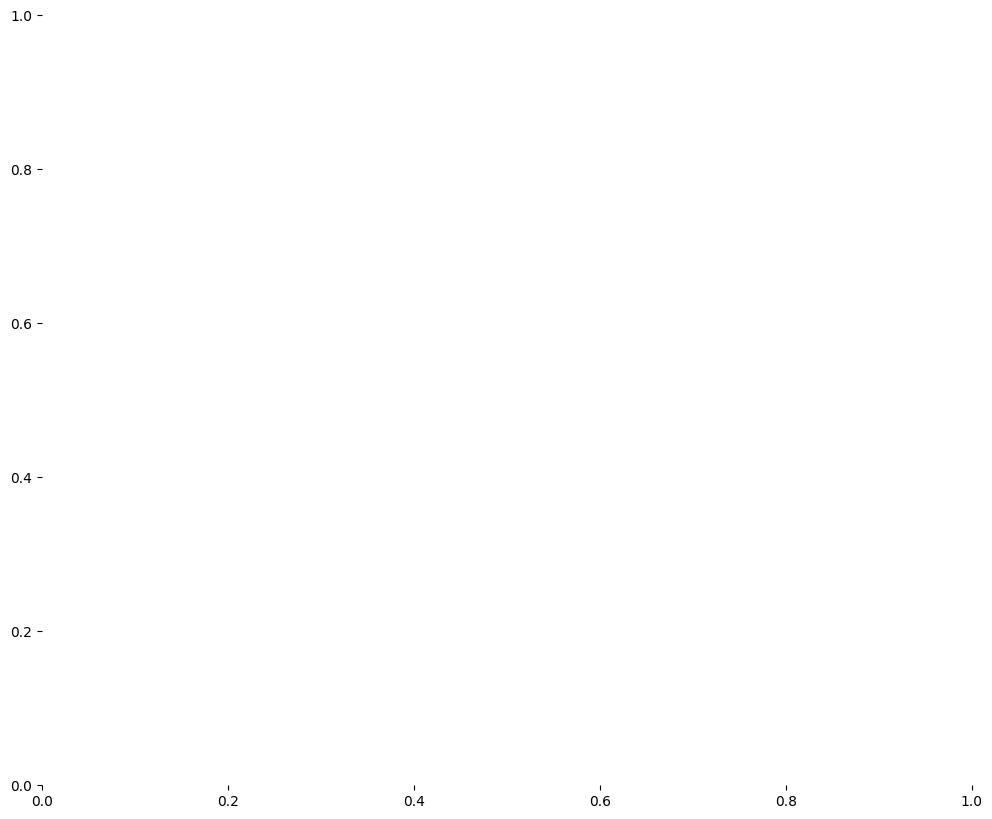

In [74]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import community as community_louvain  # python-louvain library

# Assuming graph_dist_adj_matrix is already created
# Symmetrize the matrix
graph_dist_adj_matrix = np.maximum(graph_dist_adj_matrix, graph_dist_adj_matrix.T)

# Perform Spectral Clustering
n_clusters = 3  # Adjust as needed
spectral_clustering = SpectralClustering(
    n_clusters=n_clusters, 
    affinity='precomputed', 
    assign_labels='discretize'
)

# Fit and get community labels
community_labels = spectral_clustering.fit_predict(graph_dist_adj_matrix)

# Visualization 1: Heatmap with Community Labels
plt.figure(figsize=(12, 10))
# Create a color map based on community labels
community_colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
row_colors = [community_colors[label] for label in community_labels]

sns.heatmap(graph_dist_adj_matrix, 
            cmap='YlGnBu', 
            annot=False, 
            row_colors=row_colors, 
            col_colors=row_colors)
plt.title('Graph Edit Distance Matrix with Community Colors')
plt.show()

# Visualization 2: Bar plot of community distribution
plt.figure(figsize=(10, 6))
unique, counts = np.unique(community_labels, return_counts=True)
plt.bar(unique, counts)
plt.title('Distribution of Graphs Across Communities')
plt.xlabel('Community')
plt.ylabel('Number of Graphs')
plt.show()

# Create a graph from the distance matrix for modularity calculation
# Convert distance matrix to a networkx graph
G = nx.from_numpy_array(graph_dist_adj_matrix)

# Prepare a dictionary of node communities
node_communities = {node: community_labels[node] for node in G.nodes()}

# Calculate Modularity
modularity = community_louvain.modularity(node_communities, G)

# Silhouette Score
silhouette_avg = silhouette_score(graph_dist_adj_matrix, community_labels, metric='precomputed')

print(f"Number of Communities: {n_clusters}")
print(f"Modularity Score: {modularity}")
print(f"Silhouette Score: {silhouette_avg}")

# Detailed Community Breakdown
for cluster in range(n_clusters):
    cluster_graphs = np.where(community_labels == cluster)[0]
    print(f"\nCommunity {cluster}:")
    print(f"Graphs in this community: {cluster_graphs}")
    print(f"Number of graphs: {len(cluster_graphs)}")

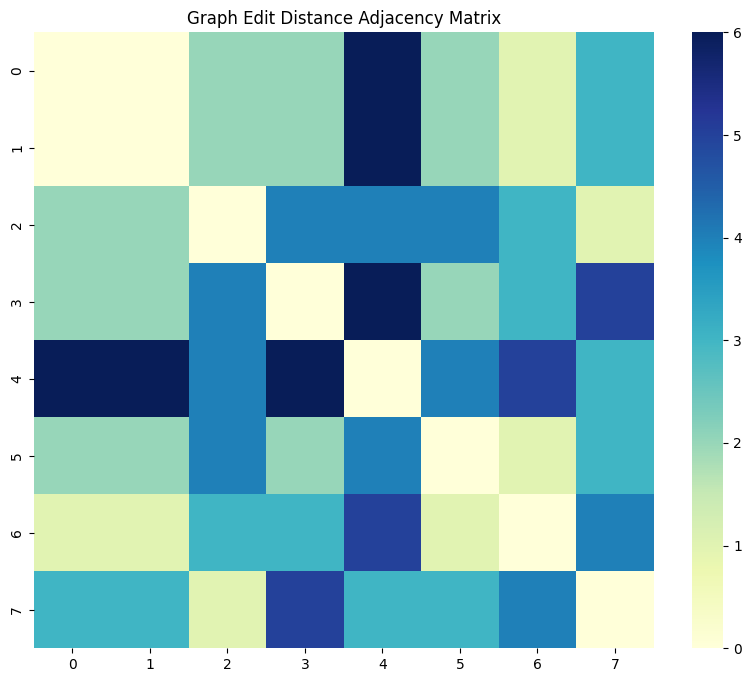

In [68]:
import seaborn as sns

# Heatmap of distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(graph_dist_adj_matrix, cmap='YlGnBu')
plt.title('Graph Edit Distance Adjacency Matrix')
plt.show()

In [71]:
from sklearn.cluster import DBSCAN

# DBSCAN can automatically detect number of clusters
dbscan = DBSCAN(
    eps=0.5,  # Adjust distance threshold
    metric='precomputed'
)

dbscan_labels = dbscan.fit_predict(graph_dist_adj_matrix)

print(dbscan_labels)

[-1 -1 -1 -1 -1 -1 -1 -1]
